Normalization stats:
Mean: tensor([   38.6503, -1853.4020])
Std: tensor([  35.0791, 1497.9106])
History range before norm: -3085.05 to 93.24
History range after norm: -1.13 to 1.56


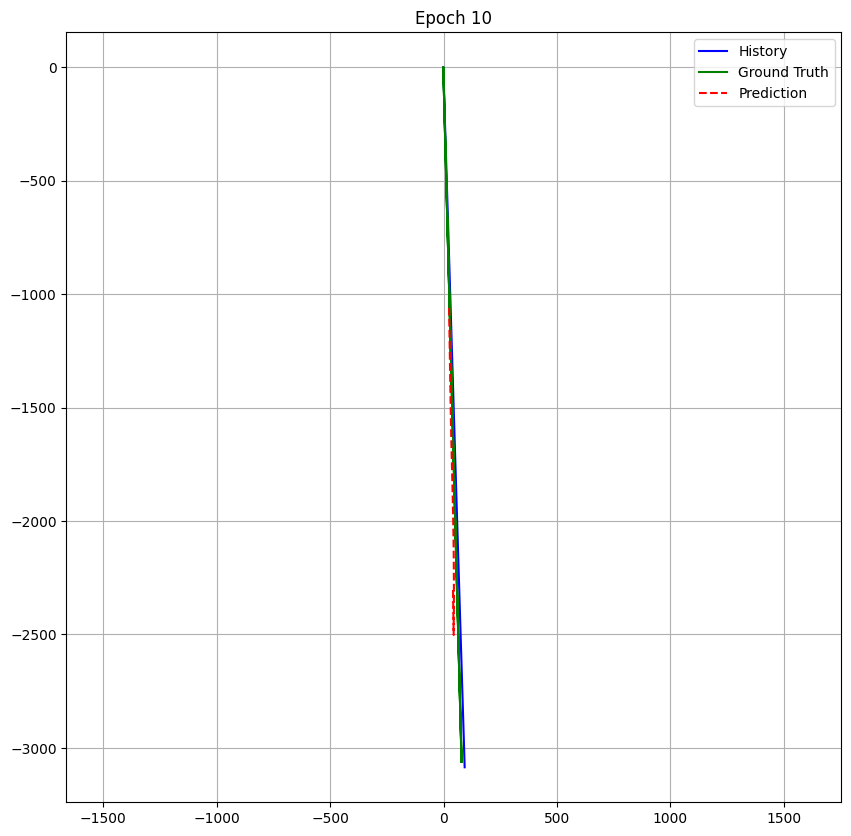

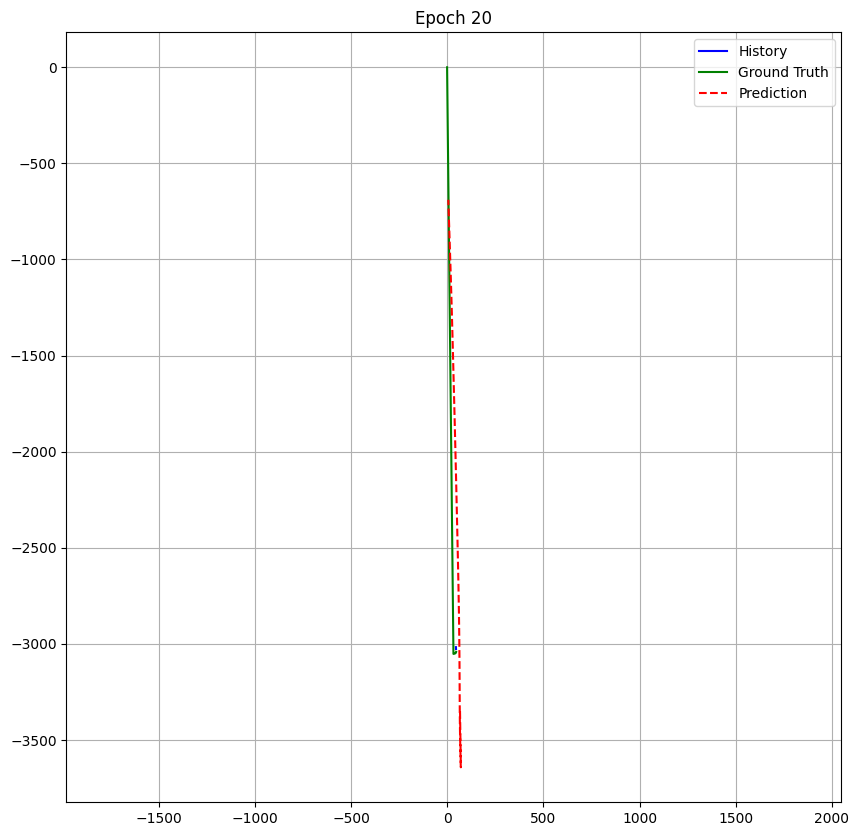

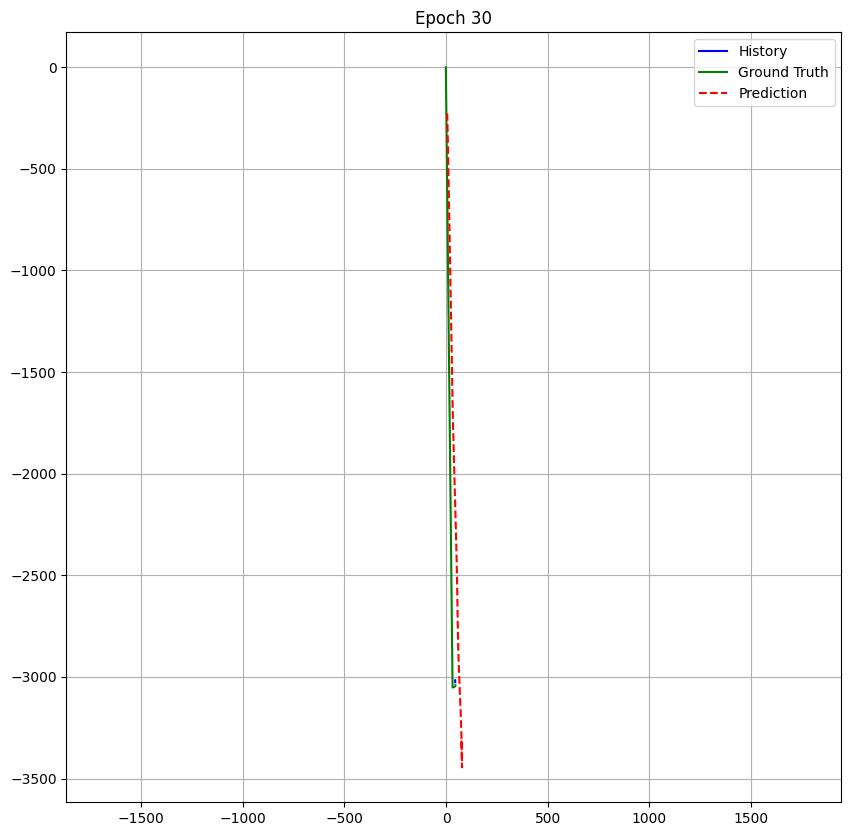

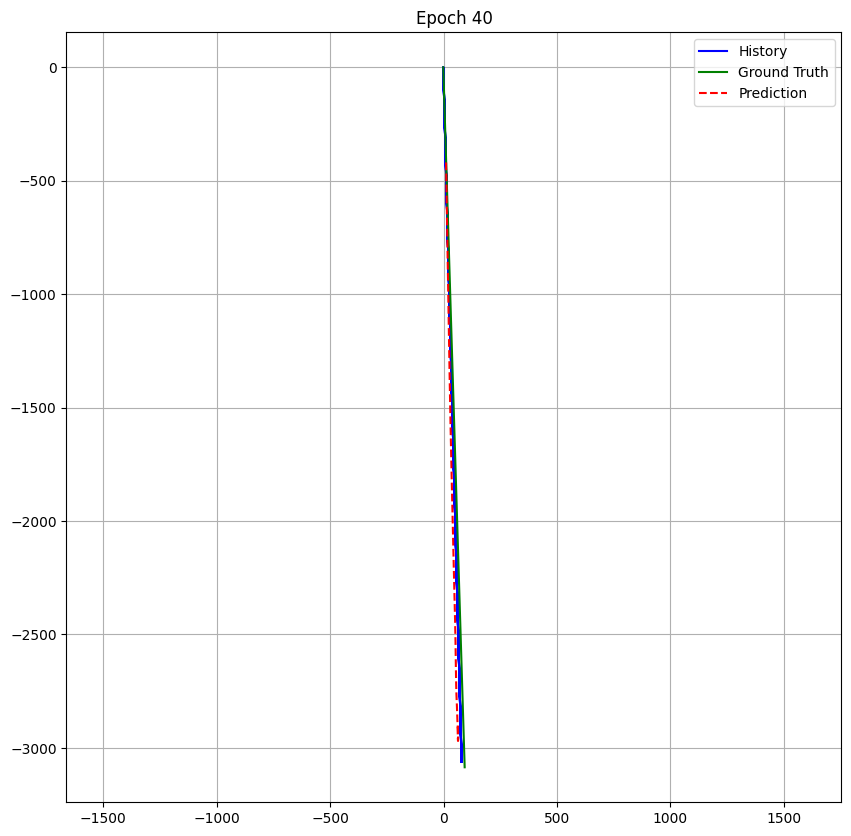

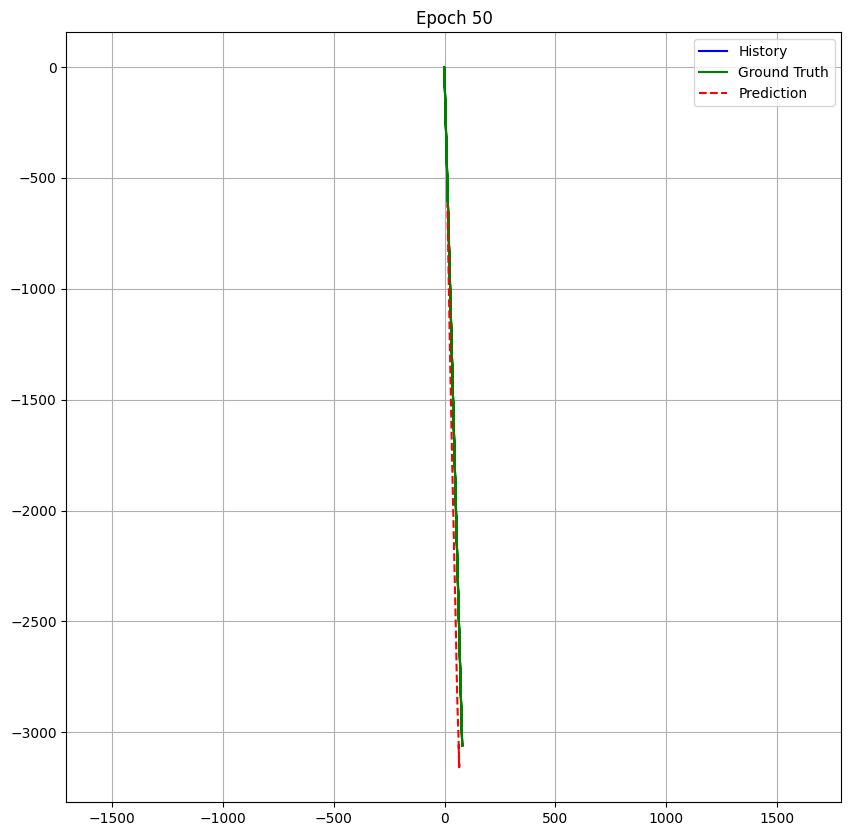

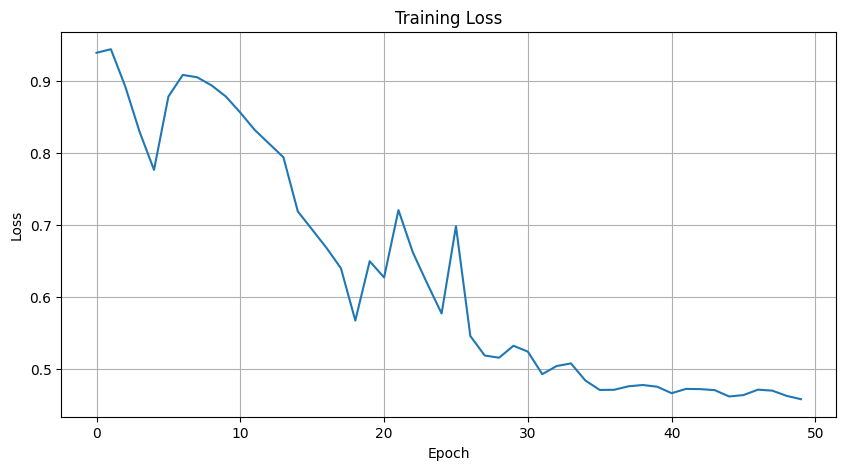

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

class TrajectoryDataset(Dataset):
    def __init__(self, data_path):
        data = np.load(data_path)
        
        valid_mask = data['agent_valid'].astype(bool)
        
        # Store original data
        self.history = torch.FloatTensor(data['history/xy'][valid_mask])
        self.future = torch.FloatTensor(data['future/xy'][valid_mask])
        self.history_valid = torch.FloatTensor(data['history/valid'][valid_mask])
        self.future_valid = torch.FloatTensor(data['future/valid'][valid_mask])
        
        # Compute statistics only on valid points
        valid_history = self.history[self.history_valid.bool()]
        valid_future = self.future[self.future_valid.bool()]
        
        # Compute mean and std across all valid points
        all_valid_points = torch.cat([valid_history, valid_future], dim=0)
        self.mean = all_valid_points.mean(dim=0)
        self.std = all_valid_points.std(dim=0)
        
        # Add small epsilon to avoid division by zero
        self.std = torch.where(self.std < 1e-6, torch.ones_like(self.std), self.std)
        
        # Normalize
        self.history_normalized = (self.history - self.mean) / self.std
        self.future_normalized = (self.future - self.mean) / self.std
        
        print("Normalization stats:")
        print(f"Mean: {self.mean}")
        print(f"Std: {self.std}")
        print(f"History range before norm: {self.history.min():.2f} to {self.history.max():.2f}")
        print(f"History range after norm: {self.history_normalized.min():.2f} to {self.history_normalized.max():.2f}")

    def __len__(self):
        return len(self.history)

    def __getitem__(self, idx):
        return ((self.history_normalized[idx], self.history_valid[idx]), 
                (self.future_normalized[idx], self.future_valid[idx]))

    def denormalize(self, data):
        """Denormalize data back to original scale"""
        return data * self.std + self.mean
    
    
    

class TrajectoryPredictor(nn.Module):
    def __init__(self, hidden_size=128):
        super().__init__()
        
        self.encoder = nn.LSTM(
            input_size=2,  # x, y coordinates
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )
        
        self.decoder = nn.LSTM(
            input_size=2,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )
        
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x, teacher_forcing_ratio=0.5):
        # x shape: [batch, 11, 2]
        batch_size = x.size(0)
        
        # Encode history
        hidden, state = self.encoder(x)
        
        # Initialize decoder input as last position
        decoder_input = x[:, -1:, :]  # shape: [batch, 1, 2]
        
        # Collect outputs
        outputs = []
        
        # Generate future trajectory
        for t in range(80):  # 80 future timesteps
            # Get decoder output
            out, state = self.decoder(decoder_input, state)
            prediction = self.fc(out)
            outputs.append(prediction)
            
            # Next input is prediction
            decoder_input = prediction
            
        return torch.cat(outputs, dim=1)

def train_model(model, train_loader, epochs=50, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch_idx, ((hist, hist_valid), (fut, fut_valid)) in enumerate(train_loader):
            hist, fut = hist.to(device), fut.to(device)
            hist_valid = hist_valid.to(device)
            fut_valid = fut_valid.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            pred = model(hist)
            
            # Calculate loss only on valid points
            loss = criterion(pred * fut_valid.unsqueeze(-1), fut * fut_valid.unsqueeze(-1))
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                hist, fut = next(iter(train_loader))[0][0][:1].to(device), next(iter(train_loader))[1][0][:1].to(device)
                pred = model(hist)
                
                # Denormalize for visualization
                hist_denorm = train_loader.dataset.denormalize(hist.cpu())
                fut_denorm = train_loader.dataset.denormalize(fut.cpu())
                pred_denorm = train_loader.dataset.denormalize(pred.cpu())
                
                hist_denorm = hist_denorm.numpy()
                fut_denorm = fut_denorm.numpy()
                pred_denorm = pred_denorm.numpy()
                
                plt.figure(figsize=(10, 10))
                plt.plot(hist_denorm[0, :, 0], hist_denorm[0, :, 1], 'b-', label='History')
                plt.plot(fut_denorm[0, :, 0], fut_denorm[0, :, 1], 'g-', label='Ground Truth')
                plt.plot(pred_denorm[0, :, 0], pred_denorm[0, :, 1], 'r--', label='Prediction')
                plt.legend()
                plt.title(f'Epoch {epoch+1}')
                plt.grid(True)
                plt.axis('equal')
                plt.show()
    torch.save(model.state_dict(), 'trajectory_model.pth')
    return model, losses

def main():
    # Load and prepare data
    dataset = TrajectoryDataset('processed_data/processed_uncompressed_tf_example_training_training_tfexample.tfrecord-00001-of-01000.npz')
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Create and train model
    model = TrajectoryPredictor()
    model, losses = train_model(model, train_loader)
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

Normalization stats:
Mean: tensor([ 3698.8401, -3814.3364])
Std: tensor([725.8935, 747.7518])
History range before norm: -3984.87 to 3896.27
History range after norm: -5.10 to 5.10


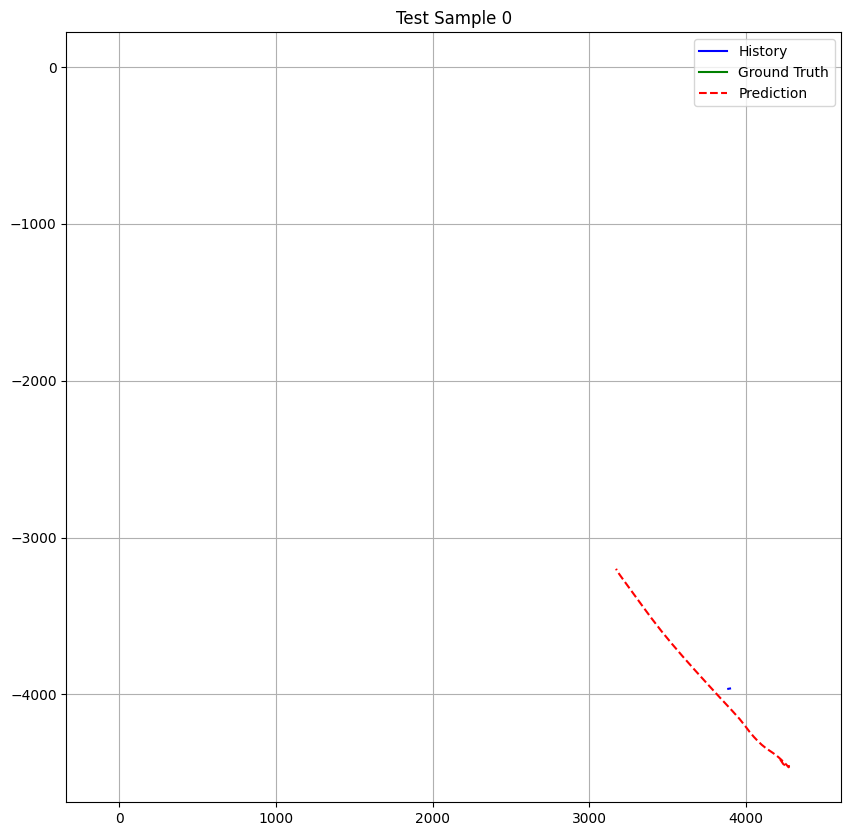

Average test error: 13913624.000000


In [8]:
def test_model(model_path, test_data_path):
   # Load the model
   model = TrajectoryPredictor()
   model.load_state_dict(torch.load(model_path))
   model.eval()
   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   model = model.to(device)
   
   # Load test data
   test_dataset = TrajectoryDataset(test_data_path)
   test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
   
   # Testing metrics
   total_error = 0
   predictions = []
   ground_truths = []
   
   with torch.no_grad():
       for i, ((hist, hist_valid), (fut, fut_valid)) in enumerate(test_loader):
           hist, fut = hist.to(device), fut.to(device)
           
           # Get prediction
           pred = model(hist)
           
           # Denormalize
           hist_denorm = test_dataset.denormalize(hist.cpu())
           fut_denorm = test_dataset.denormalize(fut.cpu())
           pred_denorm = test_dataset.denormalize(pred.cpu())
           
           # Visualize some examples
           if i % 10 == 0:  # Show every 10th prediction
               plt.figure(figsize=(10, 10))
               plt.plot(hist_denorm[0, :, 0], hist_denorm[0, :, 1], 'b-', label='History')
               plt.plot(fut_denorm[0, :, 0], fut_denorm[0, :, 1], 'g-', label='Ground Truth')
               plt.plot(pred_denorm[0, :, 0], pred_denorm[0, :, 1], 'r--', label='Prediction')
               plt.legend()
               plt.title(f'Test Sample {i}')
               plt.grid(True)
               plt.axis('equal')
               plt.show()
           
           # Calculate error
           error = ((pred_denorm - fut_denorm) ** 2).mean()
           total_error += error.item()
           
           predictions.append(pred_denorm)
           ground_truths.append(fut_denorm)
   
   avg_error = total_error / len(test_loader)
   print(f"Average test error: {avg_error:.6f}")
   
   return predictions, ground_truths, avg_error

# Example usage (update paths accordingly):
predictions, ground_truths, avg_error = test_model('trajectory_model.pth', 'processed_data_testing/processed_uncompressed_tf_example_testing_testing_tfexample.tfrecord-00001-of-00150.npz')